In [143]:
import numpy as np
def fetch(url):
    import requests, gzip, os, hashlib, numpy as np
    fp = os.path.join('tmp/' + hashlib.md5(url.encode('utf-8')).hexdigest() + '.gz')
    if os.path.isfile(fp):
        with open(fp, 'rb') as f:
            dat = f.read()
    else:
        with open(fp, 'wb') as f:
            dat = requests.get(url).content
            f.write(dat)
    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[16:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[16:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [144]:
import torch.nn as nn
import torch
class BobNet(nn.Module):
    def __init__(self):
        super(BobNet, self).__init__()
        self.l1 = nn.Linear(784, 128)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x

model = BobNet()

In [145]:
from PIL import Image

img = Image.open('./tmp/eight.png')

numpydata = np.asarray(img)



In [146]:
from tqdm import trange

In [147]:
batch = 128
optim = torch.optim.Adam(model.parameters())
for i in ( t := trange(10000)):
    samp = torch.randint(0, X_train.shape[0], (batch,))

    out = model(torch.tensor(X_train[samp]).flatten(1).float())

    loss = nn.functional.cross_entropy(out, torch.tensor(Y_train[samp]))

    optim.zero_grad()

    loss.backward()

    optim.step()

    t.set_description(f'loss {loss.item():.2f}')

loss 0.06: 100%|██████████| 10000/10000 [00:16<00:00, 599.87it/s]


In [148]:
Y_pred = torch.argmax(model(torch.tensor(X_test).flatten(1).float()), dim=1).numpy()

accuracy = (Y_pred == Y_test).mean()
accuracy

0.9643

In [149]:
import torch
import torch.nn.functional as F

/var/folders/7m/w8k84tcn19d4k10r234_g4lr0000gn/T/ipykernel_81734/842421789.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred =  torch.argmax(F.softmax(model(torch.tensor(X_train[ix]).flatten(1).float()))).item()


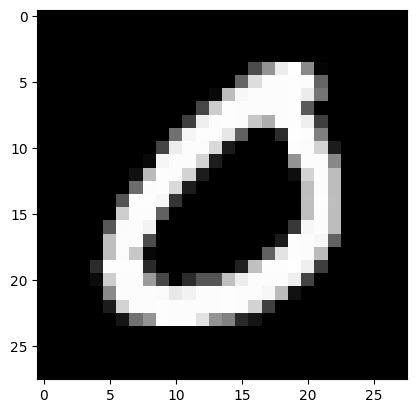

In [150]:
import matplotlib.pyplot as plt

ix = np.random.randint(0, X_train.shape[0], [1,])

pred =  torch.argmax(F.softmax(model(torch.tensor(X_train[ix]).flatten(1).float()))).item()

plt.imshow(X_train[ix].squeeze(), cmap='gray')
plt.show()

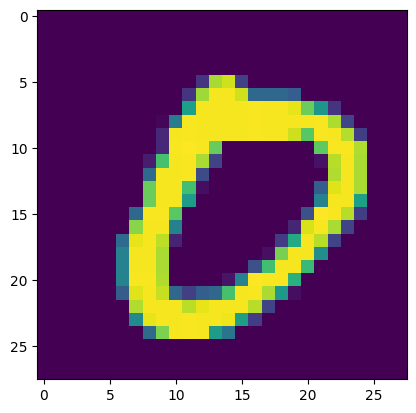

In [151]:
worst_loss = (0, 0)
for i in range(X_test.shape[0]):
    out = (model(torch.tensor(X_test[i]).flatten().float()))
    loss = F.cross_entropy(out, torch.tensor(Y_test[i])).item()
    if loss > worst_loss[1]:
        worst_loss = (i, loss)

plt.imshow(X_test[188])
plt.show()

In [168]:
l1 = model.l1.weight.detach().numpy().transpose()
l2 = model.l2.weight.detach().numpy().transpose()

In [169]:
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)
    return x

In [170]:
Y_test_preds_out = forward(X_test.reshape(-1, 28*28))

Y_test_preds = np.argmax(Y_test_preds_out, axis=1)

In [171]:
# this is the logit output of the correct number for each training example, so that later we can see the best and worst of


ret = -Y_test_preds_out[range(Y_test_preds_out.shape[0]), Y_test] + np.log(np.exp(Y_test_preds_out).sum(axis=1))
ret

/var/folders/7m/w8k84tcn19d4k10r234_g4lr0000gn/T/ipykernel_81734/4049681123.py:4: RuntimeWarning: overflow encountered in exp
  ret = -Y_test_preds_out[range(Y_test_preds_out.shape[0]), Y_test] + np.log(np.exp(Y_test_preds_out).sum(axis=1))


array([ 0., inf,  0., ...,  0.,  0.,  0.], dtype=float32)

In [156]:
import numpy as np

# Compute softmax probabilities
softmax_probs = np.exp(Y_test_preds_out) / np.sum(np.exp(Y_test_preds_out), axis=1, keepdims=True)

# Compute the loss using probabilities
ret = -np.log(softmax_probs[range(Y_test_preds_out.shape[0]), Y_test])

/var/folders/7m/w8k84tcn19d4k10r234_g4lr0000gn/T/ipykernel_81734/2050899699.py:4: RuntimeWarning: overflow encountered in exp
  softmax_probs = np.exp(Y_test_preds_out) / np.sum(np.exp(Y_test_preds_out), axis=1, keepdims=True)
/var/folders/7m/w8k84tcn19d4k10r234_g4lr0000gn/T/ipykernel_81734/2050899699.py:4: RuntimeWarning: invalid value encountered in divide
  softmax_probs = np.exp(Y_test_preds_out) / np.sum(np.exp(Y_test_preds_out), axis=1, keepdims=True)


<function matplotlib.pyplot.show(close=None, block=None)>

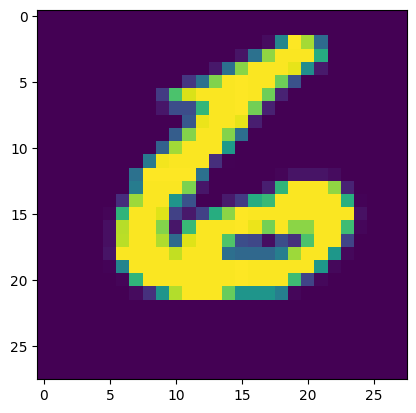

In [157]:
plt.imshow(X_test[9999])
plt.show